# Importancia de las variables en un modelo

Muchos modelos de Machine Learning suelen ser "cajas negras", es decir, entender que es lo que esta pasando con cada una de nuestras variables y como estas influyen en nuestras predicciones es dificil. Para poder explicar que es lo que esta sucediendo internamente con el modelo y como esto afecta a sus resultados, hacemos uso de técnicas explicabilidad.

Si tomamos por ejemplo a los modelos lineales, podemos utilizar la magnitud de sus coeficientes como una métrica general de la importancia de cada variable en nuestro modelo, pero hay que considerar que estos suelen tener las escalas de las variables, por lo que si no fueron correctamente estandarizadas, podemos caer en malinterpretaciones. Además los coeficientes no nos permiten hablar sobre las importancias locales de cada variable. Esto mismo sucede con las técnicas de importancia en los modelos de arboles, los cuales analizaremos ahora.

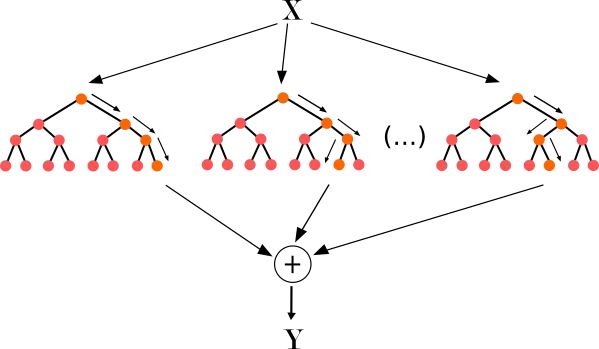

Veremos tres técnicas para visualizar la importancia de las variables en modelos de arbol:

- Importancia de Gini/ Decrecimiento medio en impureza (MDI)
- Importancia de Permutación/ Decrecimiento medio en Accuracy (MDA).
- Valores Shap.

Comenzamos viendo los dos primeros, ya que son los más tradicionales y luego de ver sus problemas, estudiaremos los valores Shap.

## Gini Importance / Mean Decrease in Impurity (MDI)


Hay dos definiciones para el MDI, la primera, según [1]:

"*La importancia de Gini calcula la importancia de cada feature como la suma sobre el número de cortes (en todos los arboles), que incluyen a esa variable, ponderada por el número de muestras en cada corte*".

Sin embargo, hay otra definición dada por Gilles en [2]. En vez de contar los "cortes", se utiliza el decrecimiento de la impuresa en cada nodo, sumandolos en todos los arboles, poderando por el número de muestras. Esta última es la implementada por scikit-learn.

## Permutation Importance or Mean Decrease in Accuracy (MDA)

Consideremos la siguiente data:

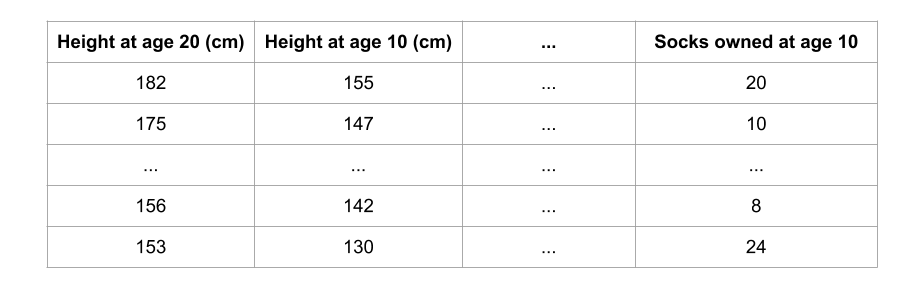

En este ejemplo, queremos predecir la altura de una persona a sus 20 años, utilizando datos que estan disponible a sus 10 años.

La información de permutación se calcula al responder la siguiente pregunta: ¿Si mezclamos al azar los valores en una sola columna, manteniendo el target y el resto de variables iguales, que tanto afectamos a nuestra función de perdida?

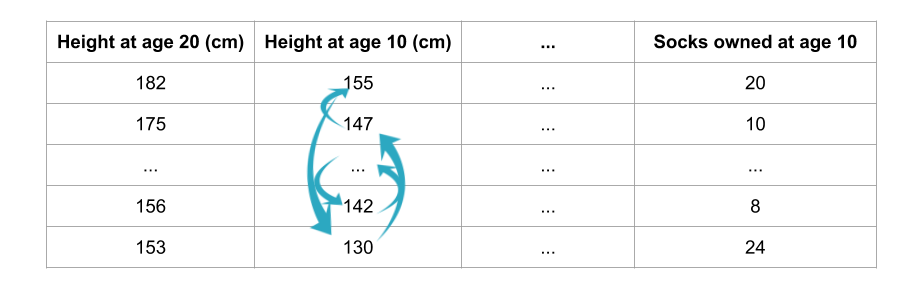

En el ejemplo de la imagen, queremos obtener la importancia de la variable **Height at age 10 (cm)**.

De esta manera, el proceso es el siguiente:

1. Entrenar el modelo.
2. Mezclar los valores en una sola columna (en este caso **Height at age 10 (cm)**).
3. Realizar predicciones utilizando el dataset resultante. 
4. Utilizar estas predicciones y los valores reales para calcular cuando se afectó a la función de perdida por mezclar los valores.
5. Esa perdida en la función de costos es la importancia de dicha columna/variable, en este caso **Height at age 10 (cm)**

## Aplicando estos dos métodos a un arbol de decisión

In [1]:
# ! pip install shap

In [2]:
# Let's load the packages
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import shap
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
import optuna 
import lightgbm as lgb

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [3]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.head()

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [5]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [18]:
rf.feature_importances_

array([0.03954136, 0.00107333, 0.00630682, 0.00116362, 0.02575838,
       0.23805331, 0.01380748, 0.06888276, 0.00259866, 0.01668813,
       0.00966838, 0.01405812, 0.56239965])

Text(0.5, 0, 'Random Forest Feature Importance')

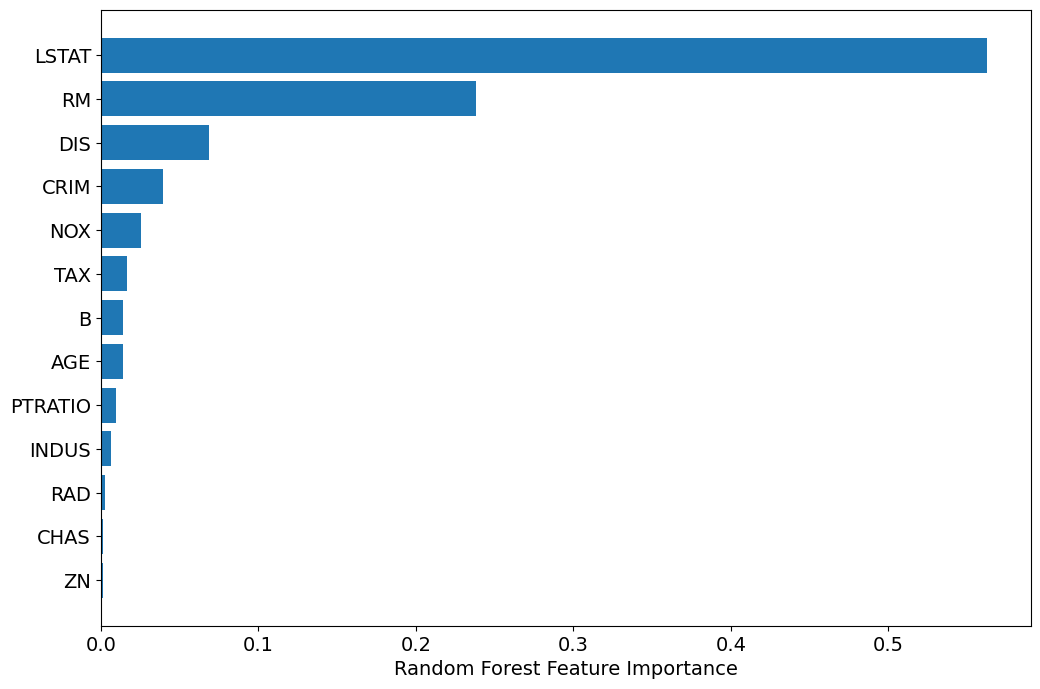

In [6]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")     

Text(0.5, 0, 'Permutation Importance')

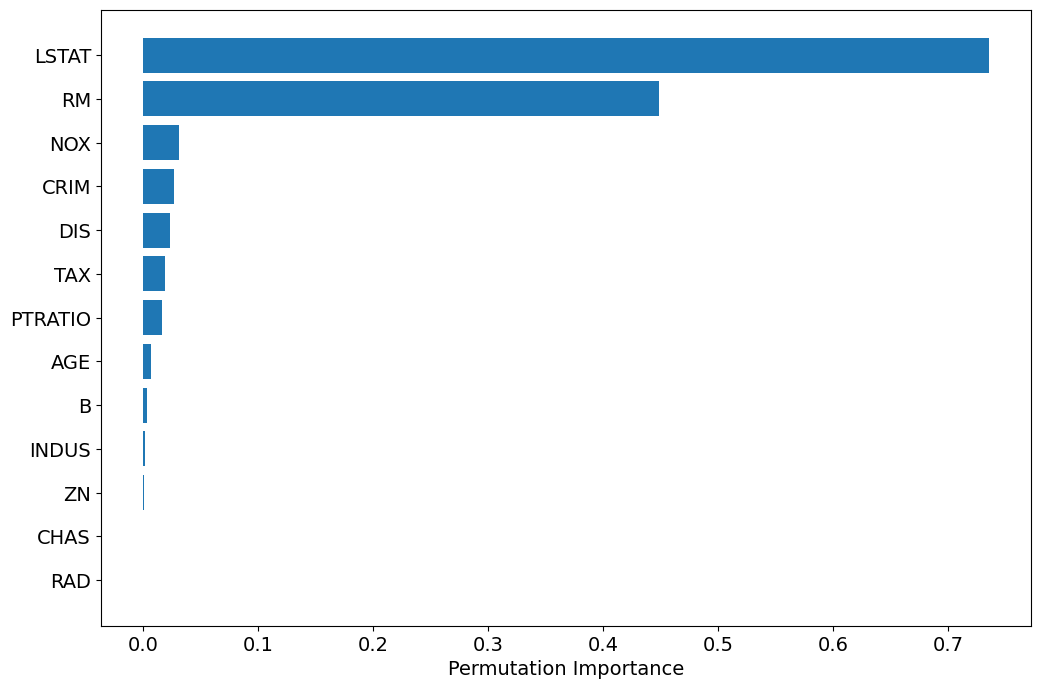

In [7]:
perm_importance = permutation_importance(rf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Podemos observar que al usar dos métodos distintos para obtener la importancia de las variables, obtenemos ordenes diferentes en los primeros lugares, por lo que perdemos "objetividad" a la hora de decidir sobre que variable debemos realizar gestión. Es por esto que nacen los valores de Shap, como una alternativa que busca dar resultados objetivos y además ayudar a la interpretabilidad de varios modelos.

## Valores de Shap

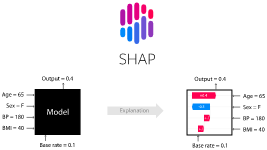
https://github.com/slundberg/shap

SHAP values (SHapley Additive exPlanations) Es un metodo basado en la teoria de juegos cooperativa, la cual nos ayuda en la transparencia e interpretabilidad de los modelos de machine learning.

Considera un juego cooperativo en donde la cantidad de features es la cantidad de jugadores. Shap busca determinar la contribución de cada jugador/feature en los resultados del modelo, para cada observación.


Para utilizarlos, basta con usar el método de la libreria **shap**, *TreeExplainer*, la cual recibe nuestro modelo previamente entrenado:

In [8]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [9]:
class ShapAnalysis():
    
    def __init__(self, df):
        shap_values = explainer(df)
        self._shap_values = shap_values
        self._instance_names = df.index.to_list()
        self._feature_names = df.columns.to_list()
        self.df_shap = pd.DataFrame(
            shap_values.values, 
            columns=df.columns, 
            index=df.index
        )
        
    def waterfall(self, i, **kwargs):
        shap_values = self._shap_values
        shap_object = shap.Explanation(
                base_values = shap_values[i][0].base_values, 
                values = shap_values[i].values,
                feature_names = self._feature_names,
                instance_names=self._instance_names,
                data = shap_values[i].data,
        )
        shap.plots.waterfall(shap_object, **kwargs)

Luego, calculamos la importancia global de nuestras variables usando el método *summary_plot* de la libreria, la cual recibe los valores shap calculados, y el conjunto de test de nuestros datos:

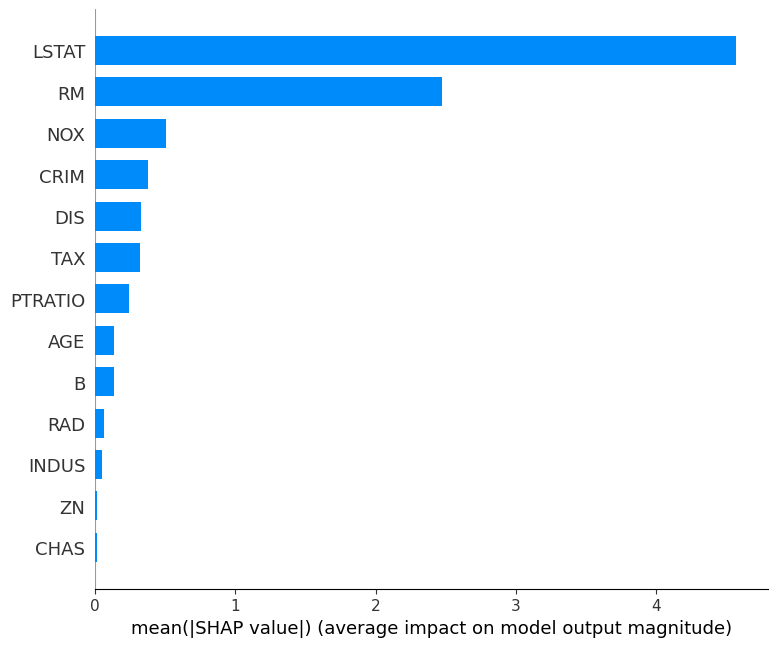

In [10]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

On the beeswarm the features are also ordered by their effect on prediction, but we can also see how higher and lower values of the feature will affect the result.

All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.

In this example, higher latitudes and longitudes have a negative impact on the prediction, while lower values have a positive impact.

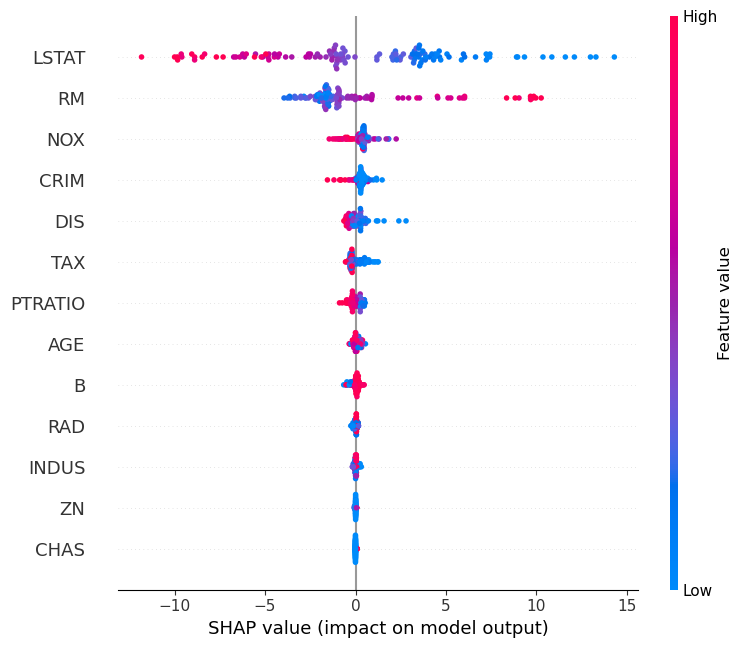

In [11]:
shap.summary_plot(shap_values, X_test)

Una de las ventajas de los valores Shap, es que nos permite ver el efecto de cada feature por observacion:

In [19]:
X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
334,0.03738,0.0,5.19,0.0,0.515,6.310,38.5,6.4584,5.0,224.0,20.2,389.40,6.75
394,13.35980,0.0,18.10,0.0,0.693,5.887,94.7,1.7821,24.0,666.0,20.2,396.90,16.35
404,41.52920,0.0,18.10,0.0,0.693,5.531,85.4,1.6074,24.0,666.0,20.2,329.46,27.38
236,0.52058,0.0,6.20,1.0,0.507,6.631,76.5,4.1480,8.0,307.0,17.4,388.45,9.54
307,0.04932,33.0,2.18,0.0,0.472,6.849,70.3,3.1827,7.0,222.0,18.4,396.90,7.53


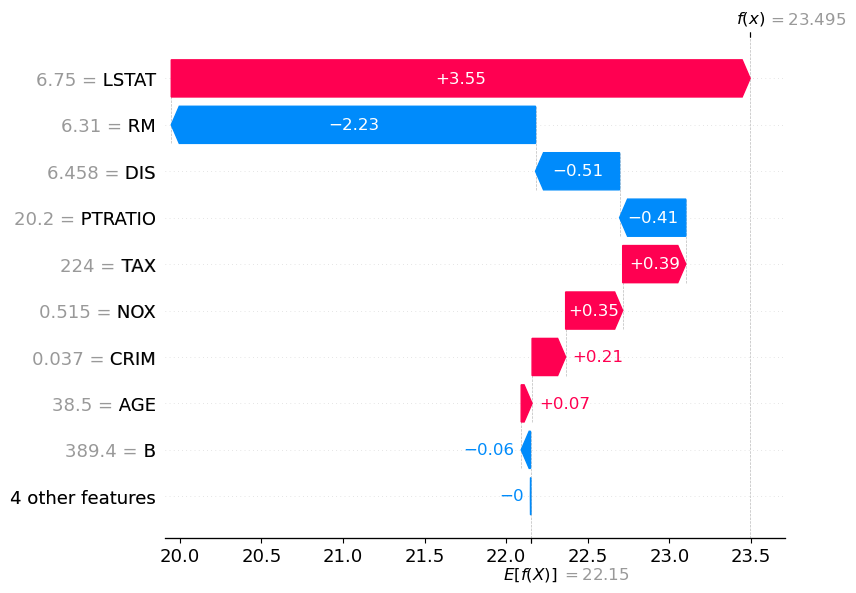

In [12]:
shap_analysis = ShapAnalysis(X_test)
shap_analysis.waterfall(0)

# Optimización de Hiperparametros con Optuna

In [13]:
# ! pip install optuna

Optuna es un framework de optimización de hiperprametros que es facilmente implementable para diferentes modelos, permitiendonos encontrar los mejores con gran rapidez y performance. Esto lo logta mediante técnicas de optimización Bayesianas

Para utilizar optuna, comenzamos definimos la funcion *objective*, la cual se encargará de realizar la optimización de hiperparametros. Su argumento es *trial*, se utiliza para armar el caso de estudio al minuto de indicar valores de busqueda para los hiper-parametros.

Esta función debe contener:
- Un diccionario con los hiperparametros del modelo. Los que se desean tunear, deben ir acompañados de un rango de valores, el cual se entrega usando *trial.suggest_...*.

- La instancia de entrenamiento del modelo.

- El calculo de la metrica que se considera para tunear los hiperparametros.

Esta función debe retornar la métrica, en el ejemplo *accuracy*

In [14]:
from sklearn.datasets import load_breast_cancer

In [15]:
def objective(trial):
    data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

Con esto, generamos un caso de estudio en optuna, en donde indicamos si minimizamos/maximizamos la función. El accuracy es una métrica que deseamos maximixar. Además realizaremos *n_trials* instancias del modelo, para buscar los hiperparametros

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-05-15 20:42:27,673] A new study created in memory with name: no-name-aa703013-1920-418e-958b-1102a13fafdd
[I 2023-05-15 20:42:27,706] Trial 0 finished with value: 0.9300699300699301 and parameters: {'lambda_l1': 2.1161938371782217e-07, 'lambda_l2': 1.7386084513213662e-06, 'num_leaves': 254, 'feature_fraction': 0.7905483640695525, 'bagging_fraction': 0.5069354178947177, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 0 with value: 0.9300699300699301.
[I 2023-05-15 20:42:27,738] Trial 1 finished with value: 0.965034965034965 and parameters: {'lambda_l1': 4.5450815782186105e-06, 'lambda_l2': 8.109811647955825, 'num_leaves': 31, 'feature_fraction': 0.4051238460942406, 'bagging_fraction': 0.8664555510502934, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 1 with value: 0.965034965034965.
[I 2023-05-15 20:42:27,808] Trial 2 finished with value: 0.958041958041958 and parameters: {'lambda_l1': 9.033736449110463e-07, 'lambda_l2': 1.4710607622415507e-07, 'num_leaves

[I 2023-05-15 20:42:28,869] Trial 22 finished with value: 0.951048951048951 and parameters: {'lambda_l1': 0.7200932909574356, 'lambda_l2': 0.00962777924556751, 'num_leaves': 110, 'feature_fraction': 0.9155560249596555, 'bagging_fraction': 0.9988405808353257, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:28,929] Trial 23 finished with value: 0.9370629370629371 and parameters: {'lambda_l1': 4.741001462124952, 'lambda_l2': 0.046136251323427906, 'num_leaves': 64, 'feature_fraction': 0.9949312901282965, 'bagging_fraction': 0.9278757807588058, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:28,986] Trial 24 finished with value: 0.965034965034965 and parameters: {'lambda_l1': 0.011729401127612017, 'lambda_l2': 1.8460433979658795, 'num_leaves': 148, 'feature_fraction': 0.7931545677328802, 'bagging_fraction': 0.8666817793891081, 'bagging_freq': 1, 'min_child_sample

[I 2023-05-15 20:42:30,327] Trial 45 finished with value: 0.9370629370629371 and parameters: {'lambda_l1': 0.4717697142422341, 'lambda_l2': 0.0027952882737864193, 'num_leaves': 150, 'feature_fraction': 0.9379341722418791, 'bagging_fraction': 0.8028130375091873, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:30,391] Trial 46 finished with value: 0.9790209790209791 and parameters: {'lambda_l1': 1.3910924896363508, 'lambda_l2': 0.06370468937154129, 'num_leaves': 86, 'feature_fraction': 0.9730388488455721, 'bagging_fraction': 0.7497922701935494, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:30,454] Trial 47 finished with value: 0.9230769230769231 and parameters: {'lambda_l1': 8.966148684672504, 'lambda_l2': 0.15605658574133616, 'num_leaves': 253, 'feature_fraction': 0.8238000124262019, 'bagging_fraction': 0.6252002792446332, 'bagging_freq': 1, 'min_child_samp

[I 2023-05-15 20:42:31,896] Trial 68 finished with value: 0.9790209790209791 and parameters: {'lambda_l1': 0.03451199133723195, 'lambda_l2': 0.000514972459527862, 'num_leaves': 47, 'feature_fraction': 0.7751495715039957, 'bagging_fraction': 0.7319532697772646, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:31,963] Trial 69 finished with value: 0.951048951048951 and parameters: {'lambda_l1': 0.2870553323594171, 'lambda_l2': 0.005809746249840459, 'num_leaves': 242, 'feature_fraction': 0.8108973025170817, 'bagging_fraction': 0.6814349936572388, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:32,030] Trial 70 finished with value: 0.972027972027972 and parameters: {'lambda_l1': 2.239955459718681, 'lambda_l2': 0.0034232463299084526, 'num_leaves': 119, 'feature_fraction': 0.8479323380960102, 'bagging_fraction': 0.7068228694401262, 'bagging_freq': 2, 'min_child_sam

[I 2023-05-15 20:42:33,469] Trial 91 finished with value: 0.958041958041958 and parameters: {'lambda_l1': 1.5757499870539757, 'lambda_l2': 0.019192421076897764, 'num_leaves': 98, 'feature_fraction': 0.9292147544607048, 'bagging_fraction': 0.8069399610755261, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:33,537] Trial 92 finished with value: 0.951048951048951 and parameters: {'lambda_l1': 0.8990927559625677, 'lambda_l2': 0.012439396711324038, 'num_leaves': 108, 'feature_fraction': 0.8738796149354473, 'bagging_fraction': 0.8628846655414739, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 11 with value: 0.986013986013986.
[I 2023-05-15 20:42:33,605] Trial 93 finished with value: 0.9370629370629371 and parameters: {'lambda_l1': 6.1060827179526935, 'lambda_l2': 0.007381412562032714, 'num_leaves': 139, 'feature_fraction': 0.9465560957689387, 'bagging_fraction': 0.7912189232670418, 'bagging_freq': 1, 'min_child_samp

In [17]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.986013986013986
  Params: 
    lambda_l1: 0.0015498963798906184
    lambda_l2: 0.07523618408747607
    num_leaves: 162
    feature_fraction: 0.6168091218647037
    bagging_fraction: 0.6768499424756454
    bagging_freq: 4
    min_child_samples: 47


###### Referencias:

- Feature Importance para modelos de arboles: 
 - https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
 - https://alexisperrier.com/datascience/2015/08/27/feature-importance-random-forests-gini-accuracy.html
 
- Valores de Shap:
https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

- Generales:
 - https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
 - https://alexisperrier.com/datascience/2015/08/27/feature-importance-random-forests-gini-accuracy.html
 - https://www.kaggle.com/code/dansbecker/permutation-importance
 
- Optuna: https://optuna.org/
- LightGBM con optuna: https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna
- Explicando diferentes métodos de selecciónn de hiperparametros: https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1